In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import getpass
import xarray as xr
!python -m pip install motuclient==1.8.4 --no-cache-dir
import motuclient
import xarray as xr
import numpy as np
!python -m pip install ffmpeg==1.4
import ffmpeg
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import pandas as pd
import dotenv
dotenv.load_dotenv("dev.env")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for motuclient: filename=motuclient-1.8.4-py3-none-any.whl size=32873 sha256=a6f0e0f170228a4d3bd040fc97e9e69986af8cc14db865b5b5dea84fc8d77c25
  Stored in directory: /tmp/pip-ephem-wheel-cache-y3rp0yqv/wheels/46/74/d1/ee3216f52d83212f10a0a5f5b94f3d99cf3d29b8ecf09c60b6
Successfully built motuclient
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=b95fb3c33d147dc0f42cf410a365b3ca7444579b3bbebfbe29e36db342b925c5
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Script to download the Sea Surface temperature data from copernicus. This is the Motu link:
https://nrt.cmems-du.eu/motu-web/Motu?action=describeproduct&service=SST_BAL_SST_L4_NRT_OBSERVATIONS_010_007_b-TDS&product=DMI-BALTIC-SST-L4-NRT-OBS_FULL_TIME_SERIE

In [10]:
# this is the directory that will be created
#path = r'/content/drive/MyDrive/MasterThesis/Data/SSTemp_pred'
path = r'/content/drive/MyDrive/MasterThesis/Predictions/Data'

#use os.mkdir() to create the directory
isExist = os.path.exists(path)
if not isExist:
    os.mkdir(path)

# Copernicus Marine Credentials
USERNAME = os.getenv("CMEMS_USERNAME")
PASSWORD = os.getenv("CMEMS_PASSWORD")

# Work directory
out_dir = path

# product and dataset IDs
serviceID = "SST_BAL_SST_L4_NRT_OBSERVATIONS_010_007_b"
productID = "DMI-BALTIC-SST-L4-NRT-OBS_FULL_TIME_SERIE" #"cmems_obs-oc_bal_bgc-plankton_my_l3-olci-300m_P1D" #-multi-1km

# variable
var = "analysed_sst"

#coordinates
lon = (9.25 , 30.25) # 9.25 to 30.25
lat = (53.25 , 65.85) #  53.25 to 65.85


# Boundary dates
start_date = datetime(2023, 5, 31, 0)
end_date = datetime(2023, 6, 26, 23)

# delta time
delta_t = start_date-end_date   # d+daydays to download by request
print(delta_t)
delta_t = timedelta(days=30)

-27 days, 1:00:00


In [11]:
# Download loop
while start_date <= end_date:
    temp_endday = start_date + delta_t
    # Output filename
    out_name = f"SST_data_{start_date.day}{start_date.month}{start_date.year}_to_{temp_endday.day}{temp_endday.month}{temp_endday.year}.nc"

    # Motuclient command line
    query = f'python -m motuclient --motu https://nrt.cmems-du.eu/motu-web/Motu \
    --service-id {serviceID}-TDS --product-id {productID} \
    --longitude-min {lon[0]} --longitude-max {lon[1]} --latitude-min {lat[0]} --latitude-max {lat[1]}\
    --date-min "{start_date}" --date-max "{temp_endday}" \
    --variable {var} \
    --out-dir {out_dir} --out-name {out_name} --user {USERNAME} --pwd {PASSWORD}'

    print(f"============== Running request on {start_date} ==============")
    # print(query[:-30])

    # Run the command
    #os.system(query)

    result = subprocess.run(query, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    error = result.stderr.decode('utf-8')

    print(output)
    print(error)

    start_date=temp_endday

print(f"============== Download completed! All files are in your directory {out_dir} ==============")

============== Running request on 2023-05-31 00:00:00 ==============
2023-06-26 08:01:50.404 [ INFO] Asynchronous mode set
2023-06-26 08:01:50.404 [ INFO] Authenticating user noehlckers for service https://nrt.cmems-du.eu/motu-web/Motu
2023-06-26 08:01:56.908 [ INFO] Requesting file to download (this can take a while)...
2023-06-26 08:02:04.353 [ INFO] Authenticating user noehlckers for service https://nrt.cmems-du.eu/motu-web/Motu
2023-06-26 08:02:16.340 [ INFO] The product is ready for download
2023-06-26 08:02:16.340 [ INFO] Downloading file (this can take a while)...
2023-06-26 08:02:16.771 [ INFO] File type: application/x-netcdf
2023-06-26 08:02:16.771 [ INFO] File size: 35.3 MB (35325308 B)
2023-06-26 08:02:16.772 [ INFO] Downloading file /content/drive/MyDrive/MasterThesis/Predictions/Data/SST_data_3152023_to_3062023.nc
2023-06-26 08:02:17.171 [ INFO] -  35.3 MB (1.1%)
2023-06-26 08:02:17.272 [ INFO] -  35.3 MB (2.2%)
2023-06-26 08:02:17.372 [ INFO] -  35.3 MB (3.3%)
2023-06-26 

In [8]:
# Merge data
merged_nc = xr.open_mfdataset(f"{out_dir}/{out_name}")

In [9]:
merged_nc

<xarray.Dataset>
Dimensions:       (time: 26, lat: 630, lon: 1038)
Coordinates:
  * time          (time) datetime64[ns] 2023-06-01 2023-06-02 ... 2023-06-26
  * lat           (lat) float32 53.26 53.28 53.3 53.32 ... 65.8 65.82 65.84
  * lon           (lon) float32 9.26 9.28 9.3 9.32 ... 29.94 29.96 29.98 30.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(26, 630, 1038), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    title:                      Baltic Sea - SST Analysis
    summary:                    DMI Sea Surface Temperature analysis created ...
    references:                 Høyer, J. L. and She, J., Optimal interpolati...
    institution:                Danish Meteorological Institute, DMI
    history:                    Version 1.0
    ...                         ...
    comment:                    IN NO EVENT SHALL DMI OR ITS REPRESENTATIVES ...
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...
    geospatial_lat_min:         53.2599983215332
    geospatial_lat_max:         65.83999633789062
    geospatial_lon_min:         9.25999927520752
    geospatial_lon_max:         30.0

In [ ]:
merged_nc["analysed_sst"].values

array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [280.83   , 280.83   , 280.83   , ...,       nan,       nan,
               nan],
        [280.82   , 280.82   , 280.82   , ...,       nan,       nan,
               nan],
        [280.81   , 280.81   , 280.81   , ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [280.86   , 280.86   , 280.87   , ...,       nan,       nan,
               nan],
        [280.84   , 280.85   , 280.86   , ...,       nan,       nan,
   

In [ ]:
# Create a date range for the desired years
date_range = pd.date_range(start_date, end_date, freq="D")

# Check if there are any missing dates in the xarray data
missing_dates = set(date_range) - set(np.array(merged_nc["time"]).tolist())

if missing_dates:
    print("The xarray data is missing data for the following dates:")
    print(missing_dates)
else:
    print("The xarray data contains data for every day in the specified range.")

The xarray data contains data for every day in the specified range.


<xarray.DataArray 'analysed_sst' (y: 630, x: 1038)>
dask.array<getitem, shape=(630, 1038), dtype=float32, chunksize=(630, 1038), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2017-09-14
  * y        (y) float32 53.26 53.28 53.3 53.32 53.34 ... 65.78 65.8 65.82 65.84
  * x        (x) float32 9.26 9.28 9.3 9.32 9.34 ... 29.94 29.96 29.98 30.0
Attributes:
    standard_name:  sea_surface_foundation_temperature
    long_name:      analysed sea surface temperature
    units:          kelvin
    comment:        
    source:         OSI-SAF and GHRSST L2P satellite SST products
    valid_min:      -300
    valid_max:      4500


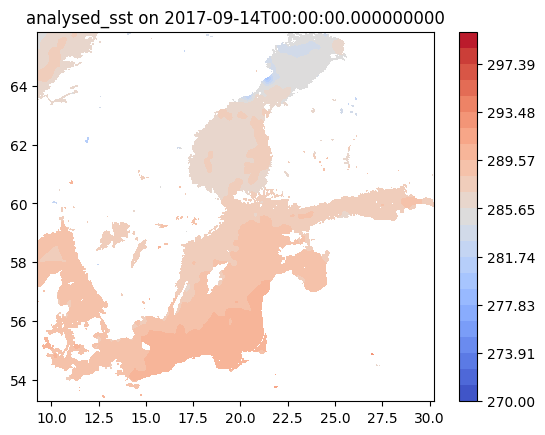

In [ ]:
ds2 = merged_nc.isel(time=500)
ds2 = ds2.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])
print(ds2['analysed_sst'])

levels = np.linspace(270, 300, 24)
img = plt.contourf(ds2['analysed_sst'], extent=[9.259,30.24,53.26,65.85], levels=levels, cmap='coolwarm')
plt.title(f'analysed_sst on {np.array(ds2["time"])}')
plt.colorbar(img)